# JTNN quickstart

First, install the package if you haven't already. If you use conda:

In [ ]:
! conda create -n jtnn_env --file conda_list.txt

Then

In [ ]:
! pip install -e .

In [1]:
import os
import pickle

# Disable CUDA (workaround for GPU memory leak issue)
os.environ["CUDA_VISIBLE_DEVICES"]=""

import tqdm
import pandas as pd

from IPython.display import display
from fast_jtnn.fp_calculator import FingerprintCalculator
from fast_jtnn.mol_tree import main_mol_tree
from fast_molvae.preprocess import create_tensor_pickle
from fast_molvae.vae_train import main_vae_train
from rdkit import Chem
from sklearn.cluster import KMeans

In [3]:
# Verify that rdkit version is 2020.09.3 as
# version 2021.03.1 does not seem to work
import rdkit
rdkit.__version__

'2020.09.3'

## Optional: Remove molecules with high-valence atoms

In [1]:
dataset = open("data/full_train.txt", "r").read().split()

In [ ]:
with open("data/full_train.txt", "w") as f:
    for smiles in tqdm.tqdm(dataset):
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            if atom.GetDegree() > 6:
                print(f"Rejecting high-valence molecule {smiles}")
                break
        else:
            f.write(smiles + "\n")

## Generate vocabulary

In [ ]:
main_mol_tree('data/full_train.txt', 'data/vocab_full.txt')

## Tensorize training set molecules

In [ ]:
create_tensor_pickle('data/full_train.txt', 'data/tensors/tensors_full.p')

## Train VAE

In [ ]:
model = main_vae_train('data/tensors/', 'data/vocab_full.txt', 'data/models', num_workers=4)

## Check that it works

In [16]:
smiles_list = open("data/full_train.txt", "r").read().split()[:5000]

In [4]:
fp_calculator = FingerprintCalculator("data/models/model.iter-20000", "data/vocab_full.txt")

/home/group/mambaforge/envs/jtnn_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [8]:
smiles_list

['COc1ccc2sc(N)nc2c1']

In [4]:
%pdb on

Automatic pdb calling has been turned ON


In [17]:
fps = fp_calculator(smiles_list)

  4%|▍         | 1/25 [00:02<01:01,  2.56s/it]RDKit WARNING: [13:22:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:22:03] WARNING: not removing hydrogen atom without neighbors
 80%|████████  | 20/25 [00:46<00:11,  2.23s/it]RDKit WARNING: [13:22:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:22:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:22:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:22:47] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 25/25 [00:57<00:00,  2.30s/it]


In [24]:
kmeans = KMeans(n_clusters=500, random_state=0).fit(fps)
labels = kmeans.labels_

In [25]:
db = pd.DataFrame()

In [26]:
db['smiles']=smiles_list
db['label']=labels

In [27]:
db

,smiles,label
0,COc1ccc2sc(N)nc2c1,61
1,CCCC(C)C1CCCN1,311
2,CCOC(=O)C1(C#N)CCN(Cc2ccccc2)CC1,134
3,O=C1CC(c2ccc(Br)cc2)CN1,457
4,CCOCc1nc(C(=O)OCC)cs1,9
...,...,...
4995,N#CCc1c[nH]c2cccc(O)c12,53
4996,CC(C)(C)OC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)[O-],171
4997,Nc1ccccc1NCCCc1ccccc1,396
4998,COC(=O)C1C(=O)CC(=O)CC1C,22


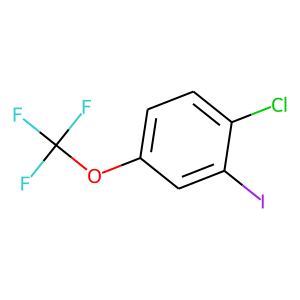

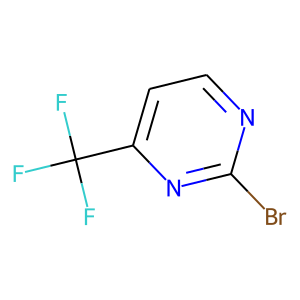

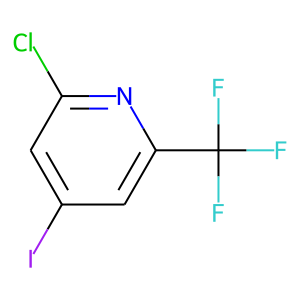

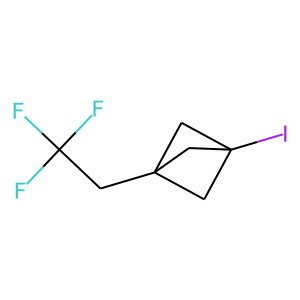

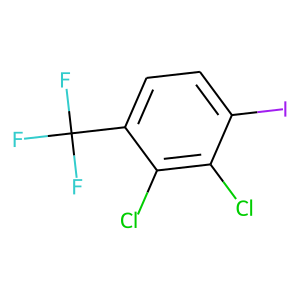

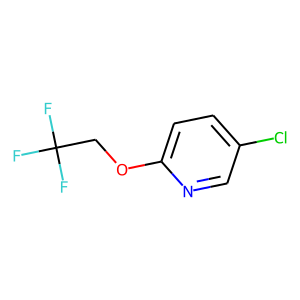

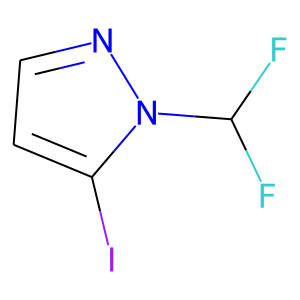

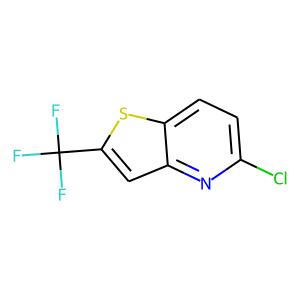

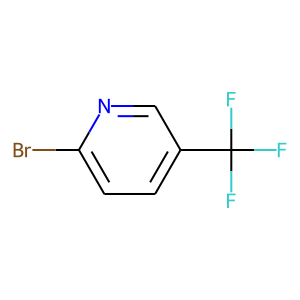

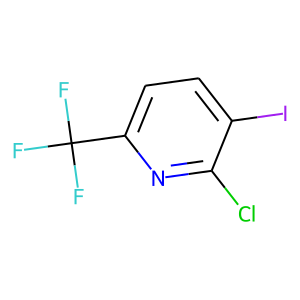

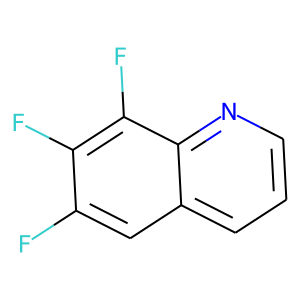

In [29]:
for smiles in db[db['label']==10]['smiles'].values:
    display(Chem.Draw.MolToImage(Chem.MolFromSmiles(smiles)))